In [60]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [61]:
vgg = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU, so freezing beforehand would have no effect.

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg.to(device)
for param in vgg.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto your GPU.

In [63]:
next(vgg.parameters()).is_cuda # Should be `True` if you have a GPU

True

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working

In [64]:
# vgg_layers = list(vgg.children())[0]

# for i in range(len(vgg_layers)):
#     if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
#         vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations. We also define `image_loader` a function which takes a relative image path, loads the image into a tensor, applies the relevant transformations to it and returns it.

We also define a convenience function `show_image` for viewing images we load using `image_loader`. For some reason pytorch doesn't seem to have any good way of visualizing tensors, so we convert the tensor to a numpy array, and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function used to add extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We definitely SHOULN'T add it here, or else our sample textures will be updated to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me.

In [65]:
transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def show_image(image_tensor):
    np_image = image_tensor.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Now we actually load in the image (and also plot it out so we can see).

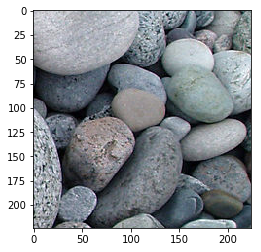

In [66]:
img_path = "data/examples/"
img_name = "stones.jpg"
full_path = img_path + img_name

example_texture = image_loader(full_path)
show_image(example_texture)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the gram matrices of the feature maps of all convolutional and pooling layers in vgg19. In order to copy them we're going to use pytorch's hook feature. 

### Hooks

Basically you define hooks as classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hooks `hook_fn` method on the layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. 

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor to the hook class instance for later use when called.

In [67]:
class SaveFeatures():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

Next we iterate through all the layers in our model and register a hook instance on each of the convolutional or pooling layers.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list, but with vgg19 at least what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [99]:
layer_feature_maps = []

for layer in list(vgg.children())[0]:
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        layer_feature_maps.append(SaveFeatures(layer))

print(len(layer_feature_maps)) # should be 21

21


Now we just run our network with all those conv and pooling layers already hooked, and the `.features` attributes of all our hook instances will automatically be populated with the feature maps of all those layers. 

In [100]:
print(type(layer_feature_maps[10].features) == type(None)) # should be True the first time you run this
vgg(example_texture)
print(layer_feature_maps[10].features[0][0][0]) # should be a tensor with random numbers in

True
tensor([ 0.0000,  0.0000,  0.0000,  1.8631,  0.0000,  0.0000,  1.2486,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0954,  0.0000,  0.0000,
         0.0000,  0.0000,  1.8045,  2.7481, 13.1464,  0.1684,  0.1790,  5.9950,
         4.7977,  0.8635,  2.3364,  0.3289], device='cuda:0')


So now we have all the feature maps we need, but for texture synthesis we want to make a gram matrix for each layer's feature maps. Let's make a helper function that takes a layer's worth of feature maps and returns a gram matrix. I copy-pasted this myself from somewhere random.

In [70]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d) # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input.

In [101]:
example_stats = [gram_matrix(layer.features) for layer in layer_feature_maps]
print(len(example_stats)) # should be 21
print(example_stats[0]) # should be a tensor. It will probably have very small values.

21
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0029, 0.0000,  ..., 0.0000, 0.0014, 0.0022],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0014, 0.0000,  ..., 0.0000, 0.0014, 0.0018],
        [0.0000, 0.0022, 0.0000,  ..., 0.0000, 0.0018, 0.0028]],
       device='cuda:0')


## Computing Loss

Next we need a way of generating a loss given the example summary statistics (above), and some sample summary statistics (which we will generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because (as we can see above) the gram matrices we calculate from the feature maps tend to be pretty damn tiny), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was *literally* just to scale the loss by some factor before returning. Gross I know. If you can find something better PLEASE let me know.

In [72]:
scale = 100 
# ideally we would pass scale in as a parameter, but then we'd also need to pass it in to
# `closure()`, and the way we're using closure doesn't allow parameters.



The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. Tl;dr: if you're using `torch.optim.LBFGS()` you can't just call `.step()` like normal, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class around it and use attribute variables on that class as parameters

As we can see, on each step we generate summary statistics on the sample texture just like we did for the example texture, and then compute the loss between these two. The optimizer we're about ti define will then perform the gradient update on the sample.

In [102]:
class GradientStepper():
    def __init__(self, optimizer, model, sample_texture, layer_feature_maps, scale):
        self.optimizer = optimizer
        self.sample_texture = sample_texture
        self.model = model
        self.layer_feature_maps = layer_feature_maps
        self.scale = scale

    def closure(self):
        self.optimizer.zero_grad() # SUPER important. If you don't understand why I am doing this 
                              # please read up on autograd and savbe yourself the carnage.

        self.model(self.sample_texture)
        sample_stats = [gram_matrix(layer.features) for layer in self.layer_feature_maps]

        loss = self.loss_fn(sample_stats, example_stats)
        loss.backward()

        print("loss: {}".format(loss))

        return loss
    
    def loss_fn(self, stats, target_stats):
        loss = 0
        for i in range(len(target_stats)):
            loss += torch.mean((stats[i] - target_stats[i]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale

## Create the Sample Texture

Nearly there! Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it until its summary statistics (i.e. gram matrices) more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them, so it should be easier to turn a smoothened random image into a natural looking image than a truly random one.


torch.Size([1, 3, 224, 224])


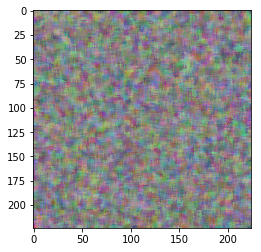

In [86]:
def random_image(blur=6):
    # create random noise numpy array
    np_sample = np.random.rand(224, 224, 3)

    # smooth it out (try commenting out this line and see the difference)
    np_sample = scipy.ndimage.filters.median_filter(np_sample, [blur, blur,1]) 

    # finally convert to a tensor with autograd enabled (since we're 
    # going to be performing gradient updates on this image)
    sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
    sample.requires_grad = True
    
    return sample

show_image(random_image())

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture and once that's done it should look a bit like the example texture (hopefully).

### Viewing Images

First things first, rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going.


### Scale

This is the nasty hack I mentioned earlier. My idea is to decrease the loss's scaling as we go so that as training proceeds we'll be making smaller and smaller gradient updates. Basically I'm kind of treating this like a learning rate.

We can't just use a normal learning rate instead, because if we don't scale the loss the gradient is always zero, and no amount of learning rate scaling will save us.


In [130]:
def make_optimizer(name, sample_texture, lr):
    if name == "LBFGS":
        return optim.LBFGS([sample_texture], lr=0.1)
    if name == "Adam":
        return optim.Adam([sample_texture], lr=0.1) 
    
    raise ValueError('Name was not a valid optimizer identifier')

In [156]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["layer_feature_maps", "model", "iterations"]:
            id += "{}{}-".format(key, params[key])
        
    return id

In [154]:
def synthesize(params):
    view_at = 1
    
    dirname = params["id"] + img_name # i've been renaming this after the hyperparameters or
    dir_path = "data/samples/{}".format(dirname)

    sample_texture = random_image(params["blur"])
    optimizer = make_optimizer(params["optimizer"], sample_texture, params["lr"]) 
    stepper = GradientStepper(optimizer, params["model"], sample_texture, params["layer_feature_maps"], params["scale"])

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    for i in range (params["iterations"]):
        if sample_texture.grad is not None:
            print(sample_texture.grad[0][0][0][:4])

        optimizer.step(stepper.closure)

        # occationally save an image so see how generation is going
        if i == view_at:
            save_image(sample_texture, "{}/lbfgs-{}.jpg".format(dir_path , view_at))
            view_at *= 2
            
            if [params["scale_decay"] > 0]:
                stepper.scale -= (stepper.scale / params["scale_decay"])

    print("sample texture finished")

In [ ]:
params = {
    "iterations": 128,
    "blur": 6,
    "scale": 10000,
    "scale_decay": 2,
    "model": vgg,
    "layer_feature_maps": layer_feature_maps,
    "optimizer": "LBFGS",
    "lr": 0.1
}

for s in [100000, 10000, 1000, 100]:
    for sd in [5, 3, 1.8, 1.2]:
        params["scale_decay"] = sd
        params["scale"] = s
        params["id"] = None
        params["id"] = identifier(params) 
        print(params["id"])

        synthesize(params)

blur6-scale100000-scale_decay5-optimizerLBFGS-lr0.1-idNone-
scale: 100000
loss: 27.19469451904297
scale: 100000
loss: 27.19321060180664
scale: 100000
loss: 26.301942825317383
scale: 100000
loss: 24.242612838745117
scale: 100000
loss: 21.884552001953125
scale: 100000
loss: 19.72907257080078
scale: 100000
loss: 18.236665725708008
scale: 100000
loss: 16.85000991821289
scale: 100000
loss: 15.718964576721191
scale: 100000
loss: 14.63674545288086
scale: 100000
loss: 13.6245698928833
scale: 100000
loss: 12.673829078674316
scale: 100000
loss: 11.735944747924805
scale: 100000
loss: 10.878963470458984
scale: 100000
loss: 10.022595405578613
scale: 100000
loss: 9.25341510772705
scale: 100000
loss: 8.564270973205566
scale: 100000
loss: 7.873290538787842
scale: 100000
loss: 7.219552993774414
scale: 100000
loss: 6.6640305519104
tensor([ 0.0003, -0.0005,  0.0001,  0.0010], device='cuda:0')
scale: 100000
loss: 6.125124454498291
scale: 100000
loss: 5.643343448638916
scale: 100000
loss: 5.218467235565185

scale: 40960.0
loss: 0.07185284048318863
scale: 40960.0
loss: 0.07160419225692749
scale: 40960.0
loss: 0.07135163247585297
scale: 40960.0
loss: 0.07105281203985214
scale: 40960.0
loss: 0.07078630477190018
scale: 40960.0
loss: 0.0705215185880661
scale: 40960.0
loss: 0.0702451765537262
scale: 40960.0
loss: 0.06998950988054276
scale: 40960.0
loss: 0.06971999257802963
scale: 40960.0
loss: 0.06946513801813126
scale: 40960.0
loss: 0.06919083744287491
tensor([-2.4106e-07,  2.5045e-07, -1.8772e-06,  1.8968e-06], device='cuda:0')
scale: 40960.0
loss: 0.06893222779035568
scale: 40960.0
loss: 0.06867238879203796
scale: 40960.0
loss: 0.0684230625629425
scale: 40960.0
loss: 0.06817314773797989
scale: 40960.0
loss: 0.06793743371963501
scale: 40960.0
loss: 0.06770007312297821
scale: 40960.0
loss: 0.06745213270187378
scale: 40960.0
loss: 0.06719167530536652
scale: 40960.0
loss: 0.06694915890693665
scale: 40960.0
loss: 0.06673678755760193
scale: 40960.0
loss: 0.06650929898023605
scale: 40960.0
loss: 0.

scale: 32768.0
loss: 0.03836894407868385
scale: 32768.0
loss: 0.038322363048791885
scale: 32768.0
loss: 0.03827991336584091
scale: 32768.0
loss: 0.03823702409863472
scale: 32768.0
loss: 0.0381929948925972
scale: 32768.0
loss: 0.03814530745148659
tensor([ 1.9887e-06, -6.6521e-07,  5.3931e-07,  3.7855e-06], device='cuda:0')
scale: 32768.0
loss: 0.038099076598882675
scale: 32768.0
loss: 0.03805247321724892
scale: 32768.0
loss: 0.038008786737918854
scale: 32768.0
loss: 0.0379648357629776
scale: 32768.0
loss: 0.03792282193899155
scale: 32768.0
loss: 0.03788234665989876
scale: 32768.0
loss: 0.037842027842998505
scale: 32768.0
loss: 0.037802811712026596
scale: 32768.0
loss: 0.03775734454393387
scale: 32768.0
loss: 0.037715960294008255
scale: 32768.0
loss: 0.03767876327037811
scale: 32768.0
loss: 0.037637870758771896
scale: 32768.0
loss: 0.03760166093707085
scale: 32768.0
loss: 0.03756443038582802
scale: 32768.0
loss: 0.0375211164355278
scale: 32768.0
loss: 0.037479743361473083
scale: 32768.0


loss: 0.033363498747348785
scale: 32768.0
loss: 0.03334715589880943
scale: 32768.0
loss: 0.033330969512462616
scale: 32768.0
loss: 0.03331468254327774
tensor([-1.2693e-06, -1.7175e-06, -8.2082e-07,  1.5330e-06], device='cuda:0')
scale: 32768.0
loss: 0.03329675644636154
scale: 32768.0
loss: 0.03328109160065651
scale: 32768.0
loss: 0.03326478600502014
scale: 32768.0
loss: 0.03324884921312332
scale: 32768.0
loss: 0.03323259577155113
scale: 32768.0
loss: 0.033215686678886414
scale: 32768.0
loss: 0.03320062905550003
scale: 32768.0
loss: 0.03318590670824051
scale: 32768.0
loss: 0.03317061811685562
scale: 32768.0
loss: 0.03315429762005806
scale: 32768.0
loss: 0.03313850238919258
scale: 32768.0
loss: 0.033122748136520386
scale: 32768.0
loss: 0.03310674801468849
scale: 32768.0
loss: 0.03309016302227974
scale: 32768.0
loss: 0.033074747771024704
scale: 32768.0
loss: 0.033059172332286835
scale: 32768.0
loss: 0.03304305300116539
scale: 32768.0
loss: 0.033028263598680496
scale: 32768.0
loss: 0.03301

scale: 26214.4
loss: 0.02488795481622219
tensor([-1.4170e-07,  8.7528e-07,  2.1745e-06,  1.4030e-07], device='cuda:0')
scale: 26214.4
loss: 0.0248807892203331
scale: 26214.4
loss: 0.02487344853579998
scale: 26214.4
loss: 0.024866456165909767
scale: 26214.4
loss: 0.024859555065631866
scale: 26214.4
loss: 0.024852769449353218
scale: 26214.4
loss: 0.024845711886882782
scale: 26214.4
loss: 0.024839146062731743
scale: 26214.4
loss: 0.024832172319293022
scale: 26214.4
loss: 0.024824636057019234
scale: 26214.4
loss: 0.02481772005558014
scale: 26214.4
loss: 0.02481098473072052
scale: 26214.4
loss: 0.024803854525089264
scale: 26214.4
loss: 0.02479666657745838
scale: 26214.4
loss: 0.024789512157440186
scale: 26214.4
loss: 0.02478219009935856
scale: 26214.4
loss: 0.024774881079792976
scale: 26214.4
loss: 0.02476782165467739
scale: 26214.4
loss: 0.024760855361819267
scale: 26214.4
loss: 0.024754246696829796
scale: 26214.4
loss: 0.024747686460614204
tensor([-1.3659e-07,  3.4860e-07,  8.4288e-07,  5

loss: 0.023853274062275887
scale: 26214.4
loss: 0.023849142715334892
scale: 26214.4
loss: 0.023844828829169273
scale: 26214.4
loss: 0.023840464651584625
scale: 26214.4
loss: 0.023836253210902214
scale: 26214.4
loss: 0.023832252249121666
scale: 26214.4
loss: 0.023827968165278435
scale: 26214.4
loss: 0.023823734372854233
scale: 26214.4
loss: 0.023819684982299805
scale: 26214.4
loss: 0.02381530962884426
scale: 26214.4
loss: 0.023810982704162598
scale: 26214.4
loss: 0.023806875571608543
scale: 26214.4
loss: 0.02380259521305561
scale: 26214.4
loss: 0.023798182606697083
scale: 26214.4
loss: 0.023793939501047134
scale: 26214.4
loss: 0.02378966473042965
scale: 26214.4
loss: 0.023785263299942017
scale: 26214.4
loss: 0.023780738934874535
scale: 26214.4
loss: 0.02377651445567608
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 26214.4
loss: 0.023772170767188072
scale: 26214.4
loss: 0.023768141865730286
scale: 26214.4
loss: 0.023763706907629967
scale: 26214.4
loss: 0.0237589702

scale: 26214.4
loss: 0.02318030409514904
scale: 26214.4
loss: 0.023177172988653183
scale: 26214.4
loss: 0.023173660039901733
scale: 26214.4
loss: 0.02317058853805065
scale: 26214.4
loss: 0.023167064413428307
scale: 26214.4
loss: 0.02316371724009514
scale: 26214.4
loss: 0.023160604760050774
scale: 26214.4
loss: 0.023157421499490738
scale: 26214.4
loss: 0.023154115304350853
scale: 26214.4
loss: 0.023150572553277016
scale: 26214.4
loss: 0.02314729057252407
scale: 26214.4
loss: 0.023144099861383438
scale: 26214.4
loss: 0.02314089983701706
scale: 26214.4
loss: 0.02313762716948986
scale: 26214.4
loss: 0.023134484887123108
scale: 26214.4
loss: 0.023131364956498146
tensor([ 3.7044e-07, -6.0395e-07, -3.1863e-07, -6.9527e-07], device='cuda:0')
scale: 26214.4
loss: 0.02312822826206684
scale: 26214.4
loss: 0.02312510833144188
scale: 26214.4
loss: 0.023122025653719902
scale: 26214.4
loss: 0.023118890821933746
scale: 26214.4
loss: 0.023115908727049828
scale: 26214.4
loss: 0.023112811148166656
scale:

loss: 0.022669624537229538
scale: 26214.4
loss: 0.02266709879040718
scale: 26214.4
loss: 0.022664587944746017
scale: 26214.4
loss: 0.022661976516246796
scale: 26214.4
loss: 0.02265956625342369
scale: 26214.4
loss: 0.022656936198472977
scale: 26214.4
loss: 0.022654658183455467
scale: 26214.4
loss: 0.022652121260762215
scale: 26214.4
loss: 0.022649556398391724
scale: 26214.4
loss: 0.022647088393568993
scale: 26214.4
loss: 0.022644514217972755
scale: 26214.4
loss: 0.022641951218247414
scale: 26214.4
loss: 0.02263922058045864
scale: 26214.4
loss: 0.022636445239186287
tensor([ 9.9898e-08, -4.7474e-08,  4.9929e-07, -5.8831e-07], device='cuda:0')
scale: 20971.52
loss: 0.01810714416205883
scale: 20971.52
loss: 0.01810636930167675
scale: 20971.52
loss: 0.01810523495078087
scale: 20971.52
loss: 0.018102921545505524
scale: 20971.52
loss: 0.018100516870617867
scale: 20971.52
loss: 0.018098287284374237
scale: 20971.52
loss: 0.01809591054916382
scale: 20971.52
loss: 0.018093610182404518
scale: 20971

scale: 20971.52
loss: 0.01781473308801651
scale: 20971.52
loss: 0.017813151702284813
scale: 20971.52
loss: 0.017811506986618042
scale: 20971.52
loss: 0.017809731885790825
scale: 20971.52
loss: 0.0178080964833498
scale: 20971.52
loss: 0.01780639961361885
scale: 20971.52
loss: 0.01780468411743641
scale: 20971.52
loss: 0.017802812159061432
scale: 20971.52
loss: 0.01780119352042675
scale: 20971.52
loss: 0.017799656838178635
scale: 20971.52
loss: 0.017797887325286865
scale: 20971.52
loss: 0.017796244472265244
scale: 20971.52
loss: 0.017794551327824593
scale: 20971.52
loss: 0.01779303327202797
scale: 20971.52
loss: 0.017791612073779106
scale: 20971.52
loss: 0.01779020018875599
tensor([ 1.9631e-07,  2.4720e-07, -8.5564e-08, -3.7133e-07], device='cuda:0')
scale: 20971.52
loss: 0.017788682132959366
scale: 20971.52
loss: 0.01778716966509819
scale: 20971.52
loss: 0.017785610631108284
scale: 20971.52
loss: 0.01778414286673069
scale: 20971.52
loss: 0.017782671377062798
scale: 20971.52
loss: 0.01778

scale: 20971.52
loss: 0.01757490634918213
scale: 20971.52
loss: 0.017573779448866844
scale: 20971.52
loss: 0.01757272519171238
scale: 20971.52
loss: 0.017571449279785156
scale: 20971.52
loss: 0.017570288851857185
scale: 20971.52
loss: 0.01756921410560608
scale: 20971.52
loss: 0.017568111419677734
scale: 20971.52
loss: 0.017566939815878868
scale: 20971.52
loss: 0.01756579615175724
scale: 20971.52
loss: 0.017564572393894196
scale: 20971.52
loss: 0.017563415691256523
scale: 20971.52
loss: 0.01756216213107109
scale: 20971.52
loss: 0.017560990527272224
scale: 20971.52
loss: 0.01755981333553791
scale: 20971.52
loss: 0.0175586249679327
scale: 20971.52
loss: 0.017557382583618164
scale: 20971.52
loss: 0.017556216567754745
scale: 20971.52
loss: 0.017554840072989464
tensor([ 4.7209e-07, -5.8877e-07, -8.0336e-07, -6.7468e-07], device='cuda:0')
scale: 20971.52
loss: 0.017553703859448433
scale: 20971.52
loss: 0.017552493140101433
scale: 20971.52
loss: 0.017551220953464508
scale: 20971.52
loss: 0.017

scale: 20971.52
loss: 0.01738855056464672
scale: 20971.52
loss: 0.01738762855529785
scale: 20971.52
loss: 0.017386652529239655
scale: 20971.52
loss: 0.017385609447956085
scale: 20971.52
loss: 0.0173846036195755
scale: 20971.52
loss: 0.01738373562693596
scale: 20971.52
loss: 0.017382727935910225
scale: 20971.52
loss: 0.017381766811013222
scale: 20971.52
loss: 0.01738075166940689
scale: 20971.52
loss: 0.017379822209477425
scale: 20971.52
loss: 0.01737896166741848
scale: 20971.52
loss: 0.017378035932779312
scale: 20971.52
loss: 0.017377052456140518
scale: 20971.52
loss: 0.01737605594098568
scale: 20971.52
loss: 0.017375053837895393
scale: 20971.52
loss: 0.017374182119965553
scale: 20971.52
loss: 0.017373260110616684
scale: 20971.52
loss: 0.017372317612171173
tensor([ 4.4751e-07,  1.2386e-07, -1.1222e-07, -6.7404e-07], device='cuda:0')
scale: 20971.52
loss: 0.017371485009789467
scale: 20971.52
loss: 0.01737058162689209
scale: 20971.52
loss: 0.017369693145155907
scale: 20971.52
loss: 0.0173

loss: 0.01723676547408104
tensor([ 4.3144e-08, -2.5006e-07, -1.3037e-07, -3.7609e-07], device='cuda:0')
scale: 20971.52
loss: 0.017236022278666496
scale: 20971.52
loss: 0.01723523996770382
scale: 20971.52
loss: 0.017234453931450844
scale: 20971.52
loss: 0.017233755439519882
scale: 20971.52
loss: 0.01723293587565422
scale: 20971.52
loss: 0.017232082784175873
scale: 20971.52
loss: 0.0172312930226326
scale: 20971.52
loss: 0.017230534926056862
scale: 20971.52
loss: 0.017229795455932617
scale: 20971.52
loss: 0.017229003831744194
scale: 20971.52
loss: 0.017228171229362488
scale: 20971.52
loss: 0.01722743920981884
scale: 20971.52
loss: 0.017226634547114372
scale: 20971.52
loss: 0.01722584292292595
scale: 20971.52
loss: 0.0172251146286726
scale: 20971.52
loss: 0.017224354669451714
scale: 20971.52
loss: 0.017223553732037544
scale: 20971.52
loss: 0.01722279004752636
scale: 20971.52
loss: 0.017221961170434952
scale: 20971.52
loss: 0.017221152782440186
tensor([ 9.8530e-08, -3.7676e-07, -3.3639e-07

scale: 20971.52
loss: 0.0171078909188509
scale: 20971.52
loss: 0.017107147723436356
scale: 20971.52
loss: 0.017106426879763603
tensor([-2.8843e-09,  2.2390e-07,  3.8776e-07,  5.4830e-07], device='cuda:0')
scale: 20971.52
loss: 0.017105745151638985
scale: 20971.52
loss: 0.017105046659708023
scale: 20971.52
loss: 0.017104366794228554
scale: 20971.52
loss: 0.01710362546145916
scale: 20971.52
loss: 0.017102882266044617
scale: 20971.52
loss: 0.017102152109146118
scale: 20971.52
loss: 0.017101401463150978
scale: 20971.52
loss: 0.017100615426898003
scale: 20971.52
loss: 0.01709992252290249
scale: 20971.52
loss: 0.01709921471774578
scale: 20971.52
loss: 0.017098456621170044
scale: 20971.52
loss: 0.017097823321819305
scale: 20971.52
loss: 0.01709722727537155
scale: 20971.52
loss: 0.017096497118473053
scale: 20971.52
loss: 0.017095763236284256
scale: 20971.52
loss: 0.017095081508159637
scale: 20971.52
loss: 0.017094392329454422
scale: 20971.52
loss: 0.01709374599158764
scale: 20971.52
loss: 0.01

loss: 0.017000140622258186
scale: 20971.52
loss: 0.01699954643845558
scale: 20971.52
loss: 0.016998980194330215
scale: 20971.52
loss: 0.016998469829559326
scale: 20971.52
loss: 0.01699789986014366
scale: 20971.52
loss: 0.016997378319501877
tensor([ 1.3695e-07,  1.5532e-07, -5.0409e-07, -7.1043e-07], device='cuda:0')
scale: 20971.52
loss: 0.0169968381524086
scale: 20971.52
loss: 0.016996251419186592
scale: 20971.52
loss: 0.016995692625641823
scale: 20971.52
loss: 0.01699516922235489
scale: 20971.52
loss: 0.016994643956422806
scale: 20971.52
loss: 0.01699412800371647
scale: 20971.52
loss: 0.01699359528720379
scale: 20971.52
loss: 0.01699305884540081
scale: 20971.52
loss: 0.016992509365081787
scale: 20971.52
loss: 0.016991999000310898
scale: 20971.52
loss: 0.016991496086120605
scale: 20971.52
loss: 0.016990989446640015
scale: 20971.52
loss: 0.016990473493933678
scale: 20971.52
loss: 0.016989940777420998
scale: 20971.52
loss: 0.01698940619826317
scale: 20971.52
loss: 0.016988858580589294
s

scale: 20971.52
loss: 0.01691114902496338
scale: 20971.52
loss: 0.0169106125831604
scale: 20971.52
loss: 0.016910135746002197
scale: 20971.52
loss: 0.016909686848521233
scale: 20971.52
loss: 0.01690921001136303
scale: 20971.52
loss: 0.01690869964659214
scale: 20971.52
loss: 0.01690823957324028
scale: 20971.52
loss: 0.016907822340726852
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 20971.52
loss: 0.01690736971795559
scale: 20971.52
loss: 0.016906917095184326
scale: 20971.52
loss: 0.01690646819770336
scale: 20971.52
loss: 0.016906000673770905
scale: 20971.52
loss: 0.016905562952160835
scale: 20971.52
loss: 0.01690514199435711
scale: 20971.52
loss: 0.01690475270152092
scale: 20971.52
loss: 0.016904335469007492
scale: 20971.52
loss: 0.016903948038816452
scale: 20971.52
loss: 0.01690351963043213
scale: 20971.52
loss: 0.01690305955708027
scale: 20971.52
loss: 0.016902683302760124
scale: 20971.52
loss: 0.016902277246117592
scale: 20971.52
loss: 0.016901874914765358
scal

scale: 29629.629629629628
loss: 0.07103060185909271
scale: 29629.629629629628
loss: 0.07052946835756302
tensor([-3.6262e-06,  7.8467e-06,  1.4137e-07,  5.6677e-08], device='cuda:0')
scale: 29629.629629629628
loss: 0.07000453025102615
scale: 29629.629629629628
loss: 0.06952202320098877
scale: 29629.629629629628
loss: 0.0690327063202858
scale: 29629.629629629628
loss: 0.06856703758239746
scale: 29629.629629629628
loss: 0.06807447224855423
scale: 29629.629629629628
loss: 0.06761126220226288
scale: 29629.629629629628
loss: 0.06716706603765488
scale: 29629.629629629628
loss: 0.06669387221336365
scale: 29629.629629629628
loss: 0.06623800098896027
scale: 29629.629629629628
loss: 0.06581289321184158
scale: 29629.629629629628
loss: 0.06541963666677475
scale: 29629.629629629628
loss: 0.06501003354787827
scale: 29629.629629629628
loss: 0.06461500376462936
scale: 29629.629629629628
loss: 0.06422343105077744
scale: 29629.629629629628
loss: 0.0638425350189209
scale: 29629.629629629628
loss: 0.063458

scale: 19753.086419753083
loss: 0.027423357591032982
scale: 19753.086419753083
loss: 0.027368703857064247
scale: 19753.086419753083
loss: 0.027316419407725334
scale: 19753.086419753083
loss: 0.027261439710855484
scale: 19753.086419753083
loss: 0.02720511332154274
scale: 19753.086419753083
loss: 0.027153218165040016
scale: 19753.086419753083
loss: 0.027101250365376472
scale: 19753.086419753083
loss: 0.027055220678448677
scale: 19753.086419753083
loss: 0.02700699307024479
scale: 19753.086419753083
loss: 0.02695942483842373
scale: 19753.086419753083
loss: 0.02690858207643032
scale: 19753.086419753083
loss: 0.026858501136302948
scale: 19753.086419753083
loss: 0.026804644614458084
scale: 19753.086419753083
loss: 0.02674952894449234
scale: 19753.086419753083
loss: 0.02669759839773178
scale: 19753.086419753083
loss: 0.026649756357073784
scale: 19753.086419753083
loss: 0.02660098299384117
tensor([ 1.5966e-06,  3.1003e-07, -2.0083e-06, -2.8117e-06], device='cuda:0')
scale: 19753.086419753083
lo

loss: 0.015012534335255623
scale: 13168.724279835387
loss: 0.014995337463915348
scale: 13168.724279835387
loss: 0.014979987405240536
scale: 13168.724279835387
loss: 0.014963935129344463
scale: 13168.724279835387
loss: 0.014947285875678062
scale: 13168.724279835387
loss: 0.014930584467947483
scale: 13168.724279835387
loss: 0.01491298247128725
scale: 13168.724279835387
loss: 0.014897027984261513
scale: 13168.724279835387
loss: 0.014880827628076077
scale: 13168.724279835387
loss: 0.014866356737911701
tensor([ 6.2345e-07, -1.5562e-06,  6.1955e-07,  8.0988e-07], device='cuda:0')
scale: 13168.724279835387
loss: 0.014851842075586319
scale: 13168.724279835387
loss: 0.014836270362138748
scale: 13168.724279835387
loss: 0.014821401797235012
scale: 13168.724279835387
loss: 0.014806217513978481
scale: 13168.724279835387
loss: 0.014790426008403301
scale: 13168.724279835387
loss: 0.014773355796933174
scale: 13168.724279835387
loss: 0.014757024124264717
scale: 13168.724279835387
loss: 0.01474203821271

scale: 13168.724279835387
loss: 0.013273029588162899
scale: 13168.724279835387
loss: 0.01326437946408987
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 13168.724279835387
loss: 0.013255766592919827
scale: 13168.724279835387
loss: 0.013247071765363216
scale: 13168.724279835387
loss: 0.013239312916994095
scale: 13168.724279835387
loss: 0.01323056872934103
scale: 13168.724279835387
loss: 0.013222155161201954
scale: 13168.724279835387
loss: 0.013213936239480972
scale: 13168.724279835387
loss: 0.013205504044890404
scale: 13168.724279835387
loss: 0.013197960332036018
scale: 13168.724279835387
loss: 0.013189850375056267
scale: 13168.724279835387
loss: 0.0131818363443017
scale: 13168.724279835387
loss: 0.013173790648579597
scale: 13168.724279835387
loss: 0.013165152631700039
scale: 13168.724279835387
loss: 0.013157105073332787
scale: 13168.724279835387
loss: 0.013149078004062176
scale: 13168.724279835387
loss: 0.013141044415533543
scale: 13168.724279835387
loss: 0.0131332

loss: 0.008235588669776917
scale: 8779.14951989026
loss: 0.008232172578573227
scale: 8779.14951989026
loss: 0.008229109458625317
scale: 8779.14951989026
loss: 0.008226035162806511
scale: 8779.14951989026
loss: 0.008222900331020355
scale: 8779.14951989026
loss: 0.008219728246331215
scale: 8779.14951989026
loss: 0.008216430433094501
scale: 8779.14951989026
loss: 0.00821316335350275
scale: 8779.14951989026
loss: 0.008209839463233948
scale: 8779.14951989026
loss: 0.008206558413803577
scale: 8779.14951989026
loss: 0.008203426375985146
scale: 8779.14951989026
loss: 0.008200222626328468
scale: 8779.14951989026
loss: 0.008197221904993057
scale: 8779.14951989026
loss: 0.008194200694561005
scale: 8779.14951989026
loss: 0.008191265165805817
tensor([ 1.4419e-07, -1.0023e-07, -3.9790e-07, -2.0532e-07], device='cuda:0')
scale: 8779.14951989026
loss: 0.00818838644772768
scale: 8779.14951989026
loss: 0.008185455575585365
scale: 8779.14951989026
loss: 0.008182664401829243
scale: 8779.14951989026
loss: 

scale: 8779.14951989026
loss: 0.00787360779941082
scale: 8779.14951989026
loss: 0.007871855050325394
tensor([-3.4458e-08,  1.6744e-08, -2.0123e-07, -1.4215e-07], device='cuda:0')
scale: 8779.14951989026
loss: 0.007869794964790344
scale: 8779.14951989026
loss: 0.007867798209190369
scale: 8779.14951989026
loss: 0.00786577071994543
scale: 8779.14951989026
loss: 0.007863882929086685
scale: 8779.14951989026
loss: 0.007862062193453312
scale: 8779.14951989026
loss: 0.007860220968723297
scale: 8779.14951989026
loss: 0.007858394645154476
scale: 8779.14951989026
loss: 0.007856504991650581
scale: 8779.14951989026
loss: 0.007854664698243141
scale: 8779.14951989026
loss: 0.007852848619222641
scale: 8779.14951989026
loss: 0.00785108469426632
scale: 8779.14951989026
loss: 0.00784916803240776
scale: 8779.14951989026
loss: 0.007847181521356106
scale: 8779.14951989026
loss: 0.007845202460885048
scale: 8779.14951989026
loss: 0.00784345343708992
scale: 8779.14951989026
loss: 0.007841657847166061
scale: 87

scale: 8779.14951989026
loss: 0.007635135669261217
scale: 8779.14951989026
loss: 0.007633767556399107
scale: 8779.14951989026
loss: 0.007632462773472071
scale: 8779.14951989026
loss: 0.007631218992173672
scale: 8779.14951989026
loss: 0.007629815489053726
scale: 8779.14951989026
loss: 0.007628553081303835
scale: 8779.14951989026
loss: 0.007627289276570082
scale: 8779.14951989026
loss: 0.007626096718013287
scale: 8779.14951989026
loss: 0.007624810561537743
scale: 8779.14951989026
loss: 0.007623543497174978
scale: 8779.14951989026
loss: 0.007622265722602606
scale: 8779.14951989026
loss: 0.007621105760335922
tensor([1.5247e-07, 4.5472e-07, 1.3574e-07, 5.2239e-07], device='cuda:0')
scale: 8779.14951989026
loss: 0.007619834039360285
scale: 8779.14951989026
loss: 0.0076185567304492
scale: 8779.14951989026
loss: 0.0076173776760697365
scale: 8779.14951989026
loss: 0.007616167888045311
scale: 8779.14951989026
loss: 0.007614854257553816
scale: 8779.14951989026
loss: 0.007613630499690771
scale: 87

loss: 0.007460641209036112
scale: 8779.14951989026
loss: 0.007459568325430155
scale: 8779.14951989026
loss: 0.007458538748323917
scale: 8779.14951989026
loss: 0.007457571569830179
scale: 8779.14951989026
loss: 0.007456581573933363
scale: 8779.14951989026
loss: 0.007455579005181789
scale: 8779.14951989026
loss: 0.0074545759707689285
scale: 8779.14951989026
loss: 0.007453638594597578
scale: 8779.14951989026
loss: 0.0074527268297970295
scale: 8779.14951989026
loss: 0.007451705634593964
scale: 8779.14951989026
loss: 0.0074506052769720554
scale: 8779.14951989026
loss: 0.007449672091752291
scale: 8779.14951989026
loss: 0.007448690012097359
scale: 8779.14951989026
loss: 0.0074477363377809525
scale: 8779.14951989026
loss: 0.0074467770755290985
scale: 8779.14951989026
loss: 0.0074458341114223
scale: 8779.14951989026
loss: 0.007444810122251511
scale: 8779.14951989026
loss: 0.007443763315677643
scale: 8779.14951989026
loss: 0.007442816626280546
scale: 8779.14951989026
loss: 0.007441881112754345
t

scale: 5852.766346593506
loss: 0.004879315849393606
scale: 5852.766346593506
loss: 0.004878750070929527
scale: 5852.766346593506
loss: 0.0048781814984977245
scale: 5852.766346593506
loss: 0.004877572413533926
scale: 5852.766346593506
loss: 0.004876996390521526
scale: 5852.766346593506
loss: 0.004876435734331608
scale: 5852.766346593506
loss: 0.004875900689512491
tensor([-1.0792e-07,  1.1715e-07,  1.4580e-08, -1.3173e-07], device='cuda:0')
scale: 5852.766346593506
loss: 0.004875298123806715
scale: 5852.766346593506
loss: 0.004874709062278271
scale: 5852.766346593506
loss: 0.004874136298894882
scale: 5852.766346593506
loss: 0.004873575642704964
scale: 5852.766346593506
loss: 0.004873002413660288
scale: 5852.766346593506
loss: 0.004872432444244623
scale: 5852.766346593506
loss: 0.004871890414506197
scale: 5852.766346593506
loss: 0.0048713237047195435
scale: 5852.766346593506
loss: 0.004870761185884476
scale: 5852.766346593506
loss: 0.004870192147791386
scale: 5852.766346593506
loss: 0.004

loss: 0.004808581899851561
scale: 5852.766346593506
loss: 0.004808192607015371
scale: 5852.766346593506
loss: 0.004807781893759966
scale: 5852.766346593506
loss: 0.004807393066585064
scale: 5852.766346593506
loss: 0.004807000048458576
scale: 5852.766346593506
loss: 0.004806590732187033
scale: 5852.766346593506
loss: 0.004806237760931253
scale: 5852.766346593506
loss: 0.004805832169950008
scale: 5852.766346593506
loss: 0.004805435426533222
scale: 5852.766346593506
loss: 0.004805035423487425
scale: 5852.766346593506
loss: 0.004804655443876982
scale: 5852.766346593506
loss: 0.004804233554750681
scale: 5852.766346593506
loss: 0.004803813528269529
scale: 5852.766346593506
loss: 0.004803413525223732
scale: 5852.766346593506
loss: 0.004802991636097431
scale: 5852.766346593506
loss: 0.00480259582400322
scale: 5852.766346593506
loss: 0.004802194889634848
scale: 5852.766346593506
loss: 0.004801778122782707
scale: 5852.766346593506
loss: 0.004801355767995119
scale: 5852.766346593506
loss: 0.00480

loss: 0.0047526368871331215
scale: 5852.766346593506
loss: 0.004752323497086763
scale: 5852.766346593506
loss: 0.004752004519104958
scale: 5852.766346593506
loss: 0.0047516850754618645
scale: 5852.766346593506
loss: 0.004751373082399368
scale: 5852.766346593506
loss: 0.004751017317175865
scale: 5852.766346593506
loss: 0.004750654101371765
scale: 5852.766346593506
loss: 0.004750307183712721
scale: 5852.766346593506
loss: 0.004749976098537445
scale: 5852.766346593506
loss: 0.004749641288071871
tensor([5.8493e-08, 6.7171e-08, 2.2015e-07, 1.2558e-07], device='cuda:0')
scale: 5852.766346593506
loss: 0.004749285988509655
scale: 5852.766346593506
loss: 0.00474894791841507
scale: 5852.766346593506
loss: 0.004748581442981958
scale: 5852.766346593506
loss: 0.004748208913952112
scale: 5852.766346593506
loss: 0.004747847095131874
scale: 5852.766346593506
loss: 0.004747497383505106
scale: 5852.766346593506
loss: 0.004747155122458935
scale: 5852.766346593506
loss: 0.0047468142583966255
scale: 5852.7

scale: 5852.766346593506
loss: 0.004707187879830599
scale: 5852.766346593506
loss: 0.004706923384219408
tensor([-5.1264e-09,  5.8135e-08,  1.1363e-07, -2.8917e-08], device='cuda:0')
scale: 5852.766346593506
loss: 0.004706664942204952
scale: 5852.766346593506
loss: 0.004706420470029116
scale: 5852.766346593506
loss: 0.004706157371401787
scale: 5852.766346593506
loss: 0.004705859813839197
scale: 5852.766346593506
loss: 0.004705572966486216
scale: 5852.766346593506
loss: 0.004705310333520174
scale: 5852.766346593506
loss: 0.0047050234861671925
scale: 5852.766346593506
loss: 0.004704754333943129
scale: 5852.766346593506
loss: 0.0047044698148965836
scale: 5852.766346593506
loss: 0.0047042155638337135
scale: 5852.766346593506
loss: 0.004703957121819258
scale: 5852.766346593506
loss: 0.004703663755208254
scale: 5852.766346593506
loss: 0.004703395068645477
scale: 5852.766346593506
loss: 0.00470314035192132
scale: 5852.766346593506
loss: 0.0047028688713908195
scale: 5852.766346593506
loss: 0.00

loss: 0.004669413901865482
scale: 5852.766346593506
loss: 0.004669178277254105
scale: 5852.766346593506
loss: 0.004668943118304014
scale: 5852.766346593506
loss: 0.004668719135224819
scale: 5852.766346593506
loss: 0.004668481647968292
scale: 5852.766346593506
loss: 0.004668243695050478
scale: 5852.766346593506
loss: 0.004668006207793951
scale: 5852.766346593506
loss: 0.004667776636779308
scale: 5852.766346593506
loss: 0.004667534027248621
scale: 5852.766346593506
loss: 0.004667293280363083
scale: 5852.766346593506
loss: 0.004667066037654877
scale: 5852.766346593506
loss: 0.004666859749704599
scale: 5852.766346593506
loss: 0.004666636232286692
scale: 5852.766346593506
loss: 0.004666391294449568
scale: 5852.766346593506
loss: 0.0046661291271448135
tensor([ 1.4402e-07,  1.5875e-07, -2.2619e-07, -1.8475e-07], device='cuda:0')
scale: 5852.766346593506
loss: 0.00466588418930769
scale: 5852.766346593506
loss: 0.004665654618293047
scale: 5852.766346593506
loss: 0.004665434826165438
scale: 5852

loss: 0.004639268387109041
scale: 5852.766346593506
loss: 0.004639094229787588
scale: 5852.766346593506
loss: 0.004638877231627703
scale: 5852.766346593506
loss: 0.004638690035790205
scale: 5852.766346593506
loss: 0.004638511221855879
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 5852.766346593506
loss: 0.004638325423002243
scale: 5852.766346593506
loss: 0.0046381414867937565
scale: 5852.766346593506
loss: 0.00463795056566596
scale: 5852.766346593506
loss: 0.004637769889086485
scale: 5852.766346593506
loss: 0.004637567326426506
scale: 5852.766346593506
loss: 0.0046373773366212845
scale: 5852.766346593506
loss: 0.004637201316654682
scale: 5852.766346593506
loss: 0.004637022968381643
scale: 5852.766346593506
loss: 0.004636842757463455
scale: 5852.766346593506
loss: 0.004636675119400024
scale: 5852.766346593506
loss: 0.004636493977159262
scale: 5852.766346593506
loss: 0.0046363226138055325
scale: 5852.766346593506
loss: 0.004636149853467941
scale: 5852.766346593506


scale: 5852.766346593506
loss: 0.004614298697561026
scale: 5852.766346593506
loss: 0.004614144563674927
scale: 5852.766346593506
loss: 0.004613985773175955
scale: 5852.766346593506
loss: 0.004613826517015696
scale: 5852.766346593506
loss: 0.004613666795194149
scale: 5852.766346593506
loss: 0.004613514058291912
scale: 5852.766346593506
loss: 0.004613358061760664
scale: 5852.766346593506
loss: 0.004613189958035946
scale: 5852.766346593506
loss: 0.004613026976585388
scale: 5852.766346593506
loss: 0.004612863063812256
scale: 5852.766346593506
loss: 0.004612715914845467
scale: 5852.766346593506
loss: 0.004612558986991644
scale: 5852.766346593506
loss: 0.004612401593476534
scale: 5852.766346593506
loss: 0.004612223710864782
scale: 5852.766346593506
loss: 0.004612077958881855
scale: 5852.766346593506
loss: 0.004611921962350607
scale: 5852.766346593506
loss: 0.004611763171851635
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 5852.766346593506
loss: 0.0046115959994494915
s

scale: 5852.766346593506
loss: 0.004591720644384623
scale: 5852.766346593506
loss: 0.004591596312820911
scale: 5852.766346593506
loss: 0.004591455217450857
scale: 5852.766346593506
loss: 0.0045913271605968475
scale: 5852.766346593506
loss: 0.0045912014320492744
scale: 5852.766346593506
loss: 0.004591065458953381
scale: 5852.766346593506
loss: 0.004590908531099558
tensor([ 5.0031e-09, -1.6226e-07, -3.2934e-07, -3.7278e-07], device='cuda:0')
scale: 5852.766346593506
loss: 0.004590779077261686
scale: 5852.766346593506
loss: 0.004590663593262434
scale: 5852.766346593506
loss: 0.004590530414134264
scale: 5852.766346593506
loss: 0.0045903935097157955
scale: 5852.766346593506
loss: 0.004590271506458521
scale: 5852.766346593506
loss: 0.004590141121298075
scale: 5852.766346593506
loss: 0.004590008407831192
scale: 5852.766346593506
loss: 0.004589876625686884
scale: 5852.766346593506
loss: 0.004589725285768509
scale: 5852.766346593506
loss: 0.004589592572301626
scale: 5852.766346593506
loss: 0.00

loss: 0.004573408979922533
scale: 5852.766346593506
loss: 0.004573287907987833
scale: 5852.766346593506
loss: 0.004573178943246603
scale: 5852.766346593506
loss: 0.0045730494894087315
scale: 5852.766346593506
loss: 0.004572938196361065
scale: 5852.766346593506
loss: 0.0045728301629424095
scale: 5852.766346593506
loss: 0.004572704900056124
scale: 5852.766346593506
loss: 0.004572576377540827
scale: 5852.766346593506
loss: 0.004572453908622265
scale: 5852.766346593506
loss: 0.004572325851768255
scale: 5852.766346593506
loss: 0.004572213627398014
scale: 5852.766346593506
loss: 0.004572093952447176
scale: 5852.766346593506
loss: 0.00457196868956089
scale: 5852.766346593506
loss: 0.004571855533868074
scale: 5852.766346593506
loss: 0.004571724217385054
scale: 5852.766346593506
loss: 0.004571597091853619
scale: 5852.766346593506
loss: 0.004571467638015747
scale: 5852.766346593506
loss: 0.004571336787194014
scale: 5852.766346593506
loss: 0.00457121804356575
scale: 5852.766346593506
loss: 0.0045

scale: 8779.149519890261
loss: 0.02459460310637951
scale: 8779.149519890261
loss: 0.024342555552721024
scale: 8779.149519890261
loss: 0.02407507225871086
scale: 8779.149519890261
loss: 0.02381221391260624
scale: 8779.149519890261
loss: 0.02358456701040268
scale: 8779.149519890261
loss: 0.023377912119030952
scale: 8779.149519890261
loss: 0.02315237559378147
scale: 8779.149519890261
loss: 0.022956769913434982
scale: 8779.149519890261
loss: 0.022763241082429886
scale: 8779.149519890261
loss: 0.022559955716133118
scale: 8779.149519890261
loss: 0.022360345348715782
scale: 8779.149519890261
loss: 0.022178692743182182
scale: 8779.149519890261
loss: 0.021985819563269615
scale: 8779.149519890261
loss: 0.0218114722520113
scale: 8779.149519890261
loss: 0.02165227010846138
scale: 8779.149519890261
loss: 0.021499434486031532
scale: 8779.149519890261
loss: 0.021338334307074547
scale: 8779.149519890261
loss: 0.021173104643821716
tensor([-2.6923e-06,  1.4636e-06,  5.8867e-06,  4.0180e-06], device='cud

loss: 0.005596373230218887
scale: 3901.8442310623386
loss: 0.005583888851106167
scale: 3901.8442310623386
loss: 0.00557222543284297
scale: 3901.8442310623386
loss: 0.005560732446610928
scale: 3901.8442310623386
loss: 0.005548965185880661
scale: 3901.8442310623386
loss: 0.005537447519600391
scale: 3901.8442310623386
loss: 0.005525079555809498
scale: 3901.8442310623386
loss: 0.005513003561645746
scale: 3901.8442310623386
loss: 0.005501371342688799
scale: 3901.8442310623386
loss: 0.005489975679665804
scale: 3901.8442310623386
loss: 0.005478803068399429
tensor([1.6323e-07, 7.8413e-07, 6.0356e-07, 1.8457e-07], device='cuda:0')
scale: 3901.8442310623386
loss: 0.005467220209538937
scale: 3901.8442310623386
loss: 0.005457020830363035
scale: 3901.8442310623386
loss: 0.005446967668831348
scale: 3901.8442310623386
loss: 0.005436394829303026
scale: 3901.8442310623386
loss: 0.005424955394119024
scale: 3901.8442310623386
loss: 0.005413955543190241
scale: 3901.8442310623386
loss: 0.005402602721005678

loss: 0.002008808543905616
scale: 1734.1529915832616
loss: 0.002006939146667719
scale: 1734.1529915832616
loss: 0.0020049489103257656
scale: 1734.1529915832616
loss: 0.002002980560064316
scale: 1734.1529915832616
loss: 0.0020008832216262817
scale: 1734.1529915832616
loss: 0.0019988124258816242
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1734.1529915832616
loss: 0.0019968783017247915
scale: 1734.1529915832616
loss: 0.0019949034322053194
scale: 1734.1529915832616
loss: 0.001993068028241396
scale: 1734.1529915832616
loss: 0.0019913793075829744
scale: 1734.1529915832616
loss: 0.001989548560231924
scale: 1734.1529915832616
loss: 0.0019875785801559687
scale: 1734.1529915832616
loss: 0.001985634444281459
scale: 1734.1529915832616
loss: 0.0019837587606161833
scale: 1734.1529915832616
loss: 0.001981914509087801
scale: 1734.1529915832616
loss: 0.0019801107700914145
scale: 1734.1529915832616
loss: 0.0019782138988375664
scale: 1734.1529915832616
loss: 0.0019764192402362823

loss: 0.001807095017284155
tensor([ 6.0203e-09,  4.1527e-08, -1.4483e-08, -1.8473e-07], device='cuda:0')
scale: 1734.1529915832616
loss: 0.0018061742885038257
scale: 1734.1529915832616
loss: 0.0018051783554255962
scale: 1734.1529915832616
loss: 0.0018042976735159755
scale: 1734.1529915832616
loss: 0.0018034601816907525
scale: 1734.1529915832616
loss: 0.0018026165198534727
scale: 1734.1529915832616
loss: 0.0018017053371295333
scale: 1734.1529915832616
loss: 0.001800826285034418
scale: 1734.1529915832616
loss: 0.00179994385689497
scale: 1734.1529915832616
loss: 0.0017990174237638712
scale: 1734.1529915832616
loss: 0.0017980486154556274
scale: 1734.1529915832616
loss: 0.0017971456982195377
scale: 1734.1529915832616
loss: 0.00179626967292279
scale: 1734.1529915832616
loss: 0.0017953761853277683
scale: 1734.1529915832616
loss: 0.0017945235595107079
scale: 1734.1529915832616
loss: 0.0017937000375241041
scale: 1734.1529915832616
loss: 0.0017928093438968062
scale: 1734.1529915832616
loss: 0.00

scale: 770.7346629258941
loss: 0.0007573366747237742
scale: 770.7346629258941
loss: 0.0007570929010398686
scale: 770.7346629258941
loss: 0.0007568362634629011
scale: 770.7346629258941
loss: 0.0007565891137346625
scale: 770.7346629258941
loss: 0.0007563352701254189
scale: 770.7346629258941
loss: 0.0007560788653790951
scale: 770.7346629258941
loss: 0.000755834043957293
scale: 770.7346629258941
loss: 0.0007555680349469185
scale: 770.7346629258941
loss: 0.0007553229224868119
scale: 770.7346629258941
loss: 0.0007550912559963763
scale: 770.7346629258941
loss: 0.0007548508583568037
scale: 770.7346629258941
loss: 0.0007546159322373569
scale: 770.7346629258941
loss: 0.0007543799583800137
scale: 770.7346629258941
loss: 0.0007541212835349143
scale: 770.7346629258941
loss: 0.0007538829813711345
scale: 770.7346629258941
loss: 0.0007536588236689568
scale: 770.7346629258941
loss: 0.0007534390897490084
scale: 770.7346629258941
loss: 0.0007531987503170967
tensor([-2.2726e-08, -3.5601e-08,  8.0132e-09, 

loss: 0.000729068648070097
scale: 770.7346629258941
loss: 0.0007289203931577504
scale: 770.7346629258941
loss: 0.0007287561311386526
scale: 770.7346629258941
loss: 0.0007286044419743121
scale: 770.7346629258941
loss: 0.0007284570019692183
scale: 770.7346629258941
loss: 0.0007282934966497123
scale: 770.7346629258941
loss: 0.0007281407015398145
scale: 770.7346629258941
loss: 0.0007280028657987714
scale: 770.7346629258941
loss: 0.0007278339471668005
scale: 770.7346629258941
loss: 0.0007276660180650651
scale: 770.7346629258941
loss: 0.0007275239331647754
tensor([-3.7479e-08, -2.4714e-08,  1.2846e-08,  9.1904e-09], device='cuda:0')
scale: 770.7346629258941
loss: 0.0007273648516274989
scale: 770.7346629258941
loss: 0.0007271954091265798
scale: 770.7346629258941
loss: 0.0007270359783433378
scale: 770.7346629258941
loss: 0.0007268690969794989
scale: 770.7346629258941
loss: 0.0007267101900652051
scale: 770.7346629258941
loss: 0.0007265605381689966
scale: 770.7346629258941
loss: 0.00072640442522

scale: 770.7346629258941
loss: 0.0007080910727381706
scale: 770.7346629258941
loss: 0.0007079800125211477
scale: 770.7346629258941
loss: 0.0007078551570884883
tensor([ 2.8051e-09, -5.7661e-09, -3.9921e-09, -2.9853e-08], device='cuda:0')
scale: 770.7346629258941
loss: 0.0007077371701598167
scale: 770.7346629258941
loss: 0.0007076229667291045
scale: 770.7346629258941
loss: 0.0007075117318890989
scale: 770.7346629258941
loss: 0.0007073985761962831
scale: 770.7346629258941
loss: 0.0007072763983160257
scale: 770.7346629258941
loss: 0.0007071611471474171
scale: 770.7346629258941
loss: 0.000707053579390049
scale: 770.7346629258941
loss: 0.0007069349521771073
scale: 770.7346629258941
loss: 0.000706810737028718
scale: 770.7346629258941
loss: 0.0007066944381222129
scale: 770.7346629258941
loss: 0.0007065803511068225
scale: 770.7346629258941
loss: 0.0007064678356982768
scale: 770.7346629258941
loss: 0.000706347927916795
scale: 770.7346629258941
loss: 0.0007062351796776056
scale: 770.7346629258941

scale: 770.7346629258941
loss: 0.0006944074993953109
scale: 770.7346629258941
loss: 0.0006943336920812726
scale: 770.7346629258941
loss: 0.0006942630861885846
scale: 770.7346629258941
loss: 0.0006941804313100874
scale: 770.7346629258941
loss: 0.000694099988322705
scale: 770.7346629258941
loss: 0.0006940278690308332
scale: 770.7346629258941
loss: 0.0006939512677490711
scale: 770.7346629258941
loss: 0.0006938767619431019
scale: 770.7346629258941
loss: 0.0006938059232197702
scale: 770.7346629258941
loss: 0.0006937277503311634
scale: 770.7346629258941
loss: 0.0006936524878256023
scale: 770.7346629258941
loss: 0.0006935783894732594
scale: 770.7346629258941
loss: 0.0006935082492418587
scale: 770.7346629258941
loss: 0.000693436071742326
scale: 770.7346629258941
loss: 0.0006933593540452421
scale: 770.7346629258941
loss: 0.000693290086928755
scale: 770.7346629258941
loss: 0.0006932122050784528
scale: 770.7346629258941
loss: 0.0006931393290869892
tensor([-0.0000, -0.0000, -0.0000, -0.0000], devi

loss: 0.0006846167962066829
scale: 770.7346629258941
loss: 0.0006845603929832578
scale: 770.7346629258941
loss: 0.000684503058437258
scale: 770.7346629258941
loss: 0.0006844417075626552
scale: 770.7346629258941
loss: 0.0006843760493211448
scale: 770.7346629258941
loss: 0.0006843110313639045
scale: 770.7346629258941
loss: 0.0006842520087957382
scale: 770.7346629258941
loss: 0.0006841903668828309
scale: 770.7346629258941
loss: 0.0006841224967502058
scale: 770.7346629258941
loss: 0.000684064463712275
scale: 770.7346629258941
loss: 0.0006840020068921149
tensor([6.2674e-09, 2.2049e-08, 4.6808e-08, 1.2930e-08], device='cuda:0')
scale: 342.5487390781752
loss: 0.0003039739967789501
scale: 342.5487390781752
loss: 0.0003039717848878354
scale: 342.5487390781752
loss: 0.0003039630828425288
scale: 342.5487390781752
loss: 0.00030394457280635834
scale: 342.5487390781752
loss: 0.00030391712789423764
scale: 342.5487390781752
loss: 0.00030388383311219513
scale: 342.5487390781752
loss: 0.0003038509748876

loss: 0.0003005068574566394
scale: 342.5487390781752
loss: 0.0003004850586876273
scale: 342.5487390781752
loss: 0.00030046285246498883
scale: 342.5487390781752
loss: 0.0003004409372806549
scale: 342.5487390781752
loss: 0.0003004182071890682
scale: 342.5487390781752
loss: 0.0003003969322890043
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 342.5487390781752
loss: 0.0003003721940331161
scale: 342.5487390781752
loss: 0.0003003486490342766
scale: 342.5487390781752
loss: 0.00030032609356567264
scale: 342.5487390781752
loss: 0.0003003018500749022
scale: 342.5487390781752
loss: 0.0003002821176778525
scale: 342.5487390781752
loss: 0.0003002583107445389
scale: 342.5487390781752
loss: 0.00030023555154912174
scale: 342.5487390781752
loss: 0.0003002095618285239
scale: 342.5487390781752
loss: 0.0003001866571139544
scale: 342.5487390781752
loss: 0.000300163752399385
scale: 342.5487390781752
loss: 0.0003001407312694937
scale: 342.5487390781752
loss: 0.0003001153818331659
scale: 

loss: 0.0002975392562802881
tensor([-6.9886e-10, -3.9037e-09, -7.9615e-09,  5.7913e-09], device='cuda:0')
scale: 342.5487390781752
loss: 0.00029752205591648817
scale: 342.5487390781752
loss: 0.00029750497196801007
scale: 342.5487390781752
loss: 0.0002974873350467533
scale: 342.5487390781752
loss: 0.00029746911604888737
scale: 342.5487390781752
loss: 0.00029745028587058187
scale: 342.5487390781752
loss: 0.00029743227059952915
scale: 342.5487390781752
loss: 0.00029741344042122364
scale: 342.5487390781752
loss: 0.00029739466845057905
scale: 342.5487390781752
loss: 0.0002973778173327446
scale: 342.5487390781752
loss: 0.0002973617520183325
scale: 342.5487390781752
loss: 0.00029734449344687164
scale: 342.5487390781752
loss: 0.00029732711846008897
scale: 342.5487390781752
loss: 0.0002973114897031337
scale: 342.5487390781752
loss: 0.0002972937363665551
scale: 342.5487390781752
loss: 0.000297276652418077
scale: 342.5487390781752
loss: 0.0002972613146994263
scale: 342.5487390781752
loss: 0.00029

scale: 342.5487390781752
loss: 0.0002952258801087737
scale: 342.5487390781752
loss: 0.00029521153192035854
scale: 342.5487390781752
loss: 0.00029519665986299515
scale: 342.5487390781752
loss: 0.0002951827773358673
scale: 342.5487390781752
loss: 0.00029516860377043486
scale: 342.5487390781752
loss: 0.00029515341157093644
scale: 342.5487390781752
loss: 0.0002951389760710299
scale: 342.5487390781752
loss: 0.00029512474429793656
scale: 342.5487390781752
loss: 0.0002951103379018605
scale: 342.5487390781752
loss: 0.0002950960479211062
scale: 342.5487390781752
loss: 0.000295081379590556
scale: 342.5487390781752
loss: 0.00029506615828722715
scale: 342.5487390781752
loss: 0.0002950519265141338
scale: 342.5487390781752
loss: 0.00029503757832571864
scale: 342.5487390781752
loss: 0.00029502337565645576
scale: 342.5487390781752
loss: 0.00029500926029868424
scale: 342.5487390781752
loss: 0.0002949940098915249
scale: 342.5487390781752
loss: 0.0002949809713754803
tensor([-0.0000, -0.0000, -0.0000, -0.

scale: 342.5487390781752
loss: 0.00029317691223695874
scale: 342.5487390781752
loss: 0.0002931622148025781
scale: 342.5487390781752
loss: 0.00029314751736819744
scale: 342.5487390781752
loss: 0.00029313398408703506
scale: 342.5487390781752
loss: 0.0002931210910901427
scale: 342.5487390781752
loss: 0.0002931079070549458
scale: 342.5487390781752
loss: 0.00029309606179594994
scale: 342.5487390781752
loss: 0.00029308279044926167
scale: 342.5487390781752
loss: 0.000293069431791082
scale: 342.5487390781752
loss: 0.00029305682983249426
scale: 342.5487390781752
loss: 0.0002930427435785532
scale: 342.5487390781752
loss: 0.00029302973416633904
scale: 342.5487390781752
loss: 0.00029301558970473707
tensor([-4.0188e-09, -2.3186e-10,  1.7074e-08,  1.1480e-08], device='cuda:0')
scale: 342.5487390781752
loss: 0.00029300188180059195
scale: 342.5487390781752
loss: 0.00029298823210410774
scale: 342.5487390781752
loss: 0.00029297557193785906
scale: 342.5487390781752
loss: 0.00029296305729076266
scale: 342

scale: 342.5487390781752
loss: 0.0002913224743679166
scale: 342.5487390781752
loss: 0.0002913092030212283
scale: 342.5487390781752
loss: 0.0002912966883741319
scale: 342.5487390781752
loss: 0.0002912836498580873
scale: 342.5487390781752
loss: 0.00029127116431482136
scale: 342.5487390781752
loss: 0.00029125873697921634
scale: 342.5487390781752
loss: 0.00029124581487849355
scale: 342.5487390781752
loss: 0.0002912330091930926
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 342.5487390781752
loss: 0.00029122064006514847
scale: 342.5487390781752
loss: 0.00029120765975676477
scale: 342.5487390781752
loss: 0.00029119563987478614
scale: 342.5487390781752
loss: 0.0002911822812166065
scale: 342.5487390781752
loss: 0.00029117133817635477
scale: 342.5487390781752
loss: 0.00029115850338712335
scale: 342.5487390781752
loss: 0.0002911449992097914
scale: 342.5487390781752
loss: 0.0002911323681473732
scale: 342.5487390781752
loss: 0.0002911199117079377
scale: 342.5487390781752
loss

scale: 342.5487390781752
loss: 0.00028955601737834513
scale: 342.5487390781752
loss: 0.00028954664594493806
scale: 342.5487390781752
loss: 0.0002895359939429909
tensor([-4.3085e-09,  3.0846e-09,  8.8787e-09, -1.7706e-08], device='cuda:0')
scale: 342.5487390781752
loss: 0.0002895263605751097
scale: 342.5487390781752
loss: 0.0002895159996114671
scale: 342.5487390781752
loss: 0.00028950494015589356
scale: 342.5487390781752
loss: 0.00028949519037269056
scale: 342.5487390781752
loss: 0.0002894843928515911
scale: 342.5487390781752
loss: 0.0002894724311772734
scale: 342.5487390781752
loss: 0.0002894613426178694
scale: 342.5487390781752
loss: 0.0002894510980695486
scale: 342.5487390781752
loss: 0.0002894401550292969
scale: 342.5487390781752
loss: 0.00028942874632775784
scale: 342.5487390781752
loss: 0.0002894174540415406
scale: 342.5487390781752
loss: 0.0002894062199629843
scale: 342.5487390781752
loss: 0.00028939495678059757
scale: 342.5487390781752
loss: 0.0002893841883633286
scale: 342.5487

scale: 342.5487390781752
loss: 0.00028795175603590906
scale: 342.5487390781752
loss: 0.00028794107493013144
scale: 342.5487390781752
loss: 0.0002879296080209315
scale: 342.5487390781752
loss: 0.0002879193052649498
scale: 342.5487390781752
loss: 0.0002879098174162209
scale: 342.5487390781752
loss: 0.00028789942734874785
scale: 342.5487390781752
loss: 0.0002878881059587002
scale: 342.5487390781752
loss: 0.00028787730843760073
scale: 342.5487390781752
loss: 0.0002878668892662972
scale: 342.5487390781752
loss: 0.00028785751783289015
scale: 342.5487390781752
loss: 0.0002878484665416181
scale: 342.5487390781752
loss: 0.00028783941525034606
scale: 342.5487390781752
loss: 0.00028782940353266895
scale: 342.5487390781752
loss: 0.00028781939181499183
scale: 342.5487390781752
loss: 0.00028780903085134923
scale: 342.5487390781752
loss: 0.00028779913554899395
scale: 342.5487390781752
loss: 0.00028779031708836555
scale: 342.5487390781752
loss: 0.0002877808001358062
tensor([-2.8363e-09, -1.9946e-09,  

scale: 342.5487390781752
loss: 0.0002864926354959607
scale: 342.5487390781752
loss: 0.00028648291481658816
scale: 342.5487390781752
loss: 0.00028647275757975876
scale: 342.5487390781752
loss: 0.00028646065038628876
scale: 342.5487390781752
loss: 0.0002864502021111548
scale: 342.5487390781752
loss: 0.0002864395792130381
scale: 342.5487390781752
loss: 0.000286428548861295
scale: 342.5487390781752
loss: 0.0002864179841708392
scale: 342.5487390781752
loss: 0.0002864076814148575
scale: 342.5487390781752
loss: 0.00028639816446229815
scale: 342.5487390781752
loss: 0.00028638733783736825
scale: 342.5487390781752
loss: 0.0002863774716388434
scale: 342.5487390781752
loss: 0.000286367314402014
tensor([ 1.1293e-09, -6.6056e-09, -3.5491e-09,  6.9529e-09], device='cuda:0')
scale: 342.5487390781752
loss: 0.00028635625494644046
scale: 342.5487390781752
loss: 0.0002863456029444933
scale: 342.5487390781752
loss: 0.00028633378678932786
scale: 342.5487390781752
loss: 0.00028632389148697257
scale: 342.5487

loss: 0.30772748589515686
scale: 16666.666666666657
loss: 0.2997848689556122
scale: 16666.666666666657
loss: 0.28645122051239014
scale: 16666.666666666657
loss: 0.2710953950881958
scale: 16666.666666666657
loss: 0.2576783299446106
scale: 16666.666666666657
loss: 0.24635529518127441
scale: 16666.666666666657
loss: 0.23565109074115753
scale: 16666.666666666657
loss: 0.22575204074382782
scale: 16666.666666666657
loss: 0.21683432161808014
scale: 16666.666666666657
loss: 0.20867981016635895
scale: 16666.666666666657
loss: 0.201127827167511
scale: 16666.666666666657
loss: 0.1937156617641449
scale: 16666.666666666657
loss: 0.18692179024219513
scale: 16666.666666666657
loss: 0.18043003976345062
scale: 16666.666666666657
loss: 0.1740676909685135
scale: 16666.666666666657
loss: 0.16792812943458557
scale: 16666.666666666657
loss: 0.1622965782880783
scale: 16666.666666666657
loss: 0.15680743753910065
tensor([0.0000, 0.0001, 0.0000, 0.0000], device='cuda:0')
scale: 2777.7777777777756
loss: 0.025238

loss: 0.00014174029638525099
scale: 77.1604938271604
loss: 0.0001412184938089922
scale: 77.1604938271604
loss: 0.0001406462542945519
scale: 77.1604938271604
loss: 0.0001401200715918094
scale: 77.1604938271604
loss: 0.00013953917368780822
scale: 77.1604938271604
loss: 0.00013899666373617947
scale: 77.1604938271604
loss: 0.00013845930516254157
scale: 77.1604938271604
loss: 0.00013794914411846548
scale: 77.1604938271604
loss: 0.00013740218128077686
scale: 77.1604938271604
loss: 0.00013680262782145292
scale: 77.1604938271604
loss: 0.00013621464313473552
tensor([ 1.8367e-08,  1.6455e-09, -4.9931e-09,  5.9529e-09], device='cuda:0')
scale: 77.1604938271604
loss: 0.00013563544780481607
scale: 77.1604938271604
loss: 0.0001350209058728069
scale: 77.1604938271604
loss: 0.0001344155170954764
scale: 77.1604938271604
loss: 0.00013386567297857255
scale: 77.1604938271604
loss: 0.00013328959175851196
scale: 77.1604938271604
loss: 0.00013268887414596975
scale: 77.1604938271604
loss: 0.000132109737023711